# Develop an image caption generator model using Tensorflow-keras

In this notebook, we will have to train a caption generator model for images. It requires a CNN model to extract the content of images and an RNN model to learn the corresponding captions of the images. These two features are finally merged and trained using dense layers.

The below research papers are for your reference-
1. [Where to put the Image in an Image Caption Generator](https://arxiv.org/abs/1703.09137)
2. [Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) 

This notebook is divided into six parts. =

1. Download photo and caption dataset
2. Prepare photo data 
3. Prepare text data 
4. Develop deep learning model with progressive data loading 
5. Evaluate model 
6. Generate new captions 

# 1. Download photo and caption dataset

In [ ]:
#Downloaded to Google Drive and unzipped
#mapping Google Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pwd

/content


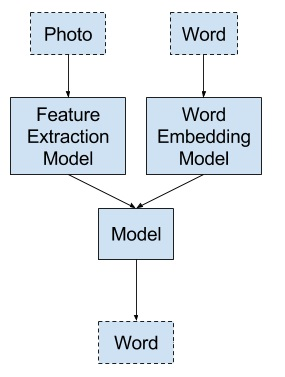

In [ ]:

from IPython.display import Image
Image(filename="gdrive/My Drive/Model-Generate-Word-From-Word.jpg")


# 2. Prepare photo data 

In [1]:
from os import listdir
from pickle import dump
#from tensorflow.keras import layers
#from tensorflow import keras 
#import tensorflow as tf

# You need to import the following functions from tensorflow.keras library
# VGG16, load_img, img_to_array, preprocess_input, Model

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import load_img
from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input


In [2]:
# function to extract features from each photo in the directory
def extract_features(directory):
	# load the VGG16 model
	model = VGG16()
  # Print the model summary to understand the model
	print(model.summary())

	# re-structure the model by removing the last layer
	#####
	model._layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

	# summarize
	print(model.summary())
  
	# extract features from each photo in a dictionary
	features = dict()
  
	# iterate over all the files of the dataset directory
	for name in listdir(directory):
		
		filename = directory + '/' + name
		# load the image from filename with target size of (224,224)
		image = load_img(filename, target_size=(224, 224))
    
		# convert the image pixels to a numpy array
		image = img_to_array(image)

		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

		# preprocess the image for the VGG model	
		image = preprocess_input(image)
    
		# get features (output of the model for the image)
		feature = model.predict(image, verbose=0)

		# get image id
		image_id = name.split('.')[0]
		
		# store feature in the features dictionary with image_id as key and feature as value
		features[image_id] = feature

	return features

# extract features from all images
directory = "gdrive/My Drive/Flicker8k_Dataset"
!ls directory
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open("gdrive/My Drive/features.pkl", 'wb'))

# 3. Prepare Text Data

In [3]:
import string

# load doc into memory
def load_doc(filename):
	# open the file as read only
    file = open(filename,'r')
	# read all text
    text = file.read()
	# close the file
    file.close()
    return text

In [4]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
	# process lines
    for line in doc.split('\n'):
		# split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
		# take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]

		# remove filename from image id
        image_id = image_id.split('.')[0]

		# convert description tokens back to string
        image_desc = ' '.join(image_desc)
	
		# create the list if neededab
        if image_id not in mapping:
            mapping[image_id] = list()
	 
		# store description
        mapping[image_id].append(image_desc)
    return mapping

In [5]:
# We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

# 1. Convert all words to lowercase.
# 2. Remove all punctuation.
# 3. Remove all words that are one character or less in length (e.g. ‘a’).
# 4. Remove all words with numbers in them.

def clean_descriptions(descriptions):
	
	# prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]

			# tokenize desc using split 
            desc = desc.split()

			# convert all the words in desc to lower case
            desc = [word.lower() for word in desc]

			# remove punctuation from each token using translate function 
			# pass the "table" variable to this function
            desc = [w.translate(table) for w in desc]

			# remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]

			# remove tokens with numbers in them using isalpha
            desc = [word for word in desc if word.isalpha()]
			# store as string
            desc_list[i] =  ' '.join(desc)

In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):

	# build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [7]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [8]:
# Use the above functions in the code below-

filename = "gdrive/My Drive/Flickr8k_text/Flickr8k.token.txt"

# load descriptions (pass the filename)
doc = load_doc(filename)

# parse descriptions (pass doc)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# clean the descriptions
#####
clean_descriptions(descriptions)

# summarize descriptions to a vocabulary of words
 
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, 'descriptions.txt')

# You should get the following output for the above code

Loaded: 8092 
Vocabulary Size: 8763


# 4. Develop Deep Learning Model

In [9]:
from numpy import array
from pickle import load

# You need to import the following functions from tensorflow.keras library
# Tokenizer, pad_sequences, to_categorical, plot_model, Model, Input, Dense, LSTM, Embedding, Dropout, add, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	# load document filename using the function defined earlier
	doc = load_doc(filename)
	dataset = list()
 
	# process doc line by line using split
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document filename using function defined earlier
	doc = load_doc(filename)
	descriptions = dict()
 
  # process doc line by line using split
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()

		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features from filename
	all_features = load(open(filename, 'rb'))

	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	# Convert the descriptions to lines
    lines = to_lines(descriptions)
  
	# Create a tokenizer object
    tokenizer = Tokenizer()

	# fit the tokenizer using fit_on_texts on lines
	#####
    tokenizer.fit_on_texts(lines)

    return tokenizer

# calculate the length of the description with the most words
def mlength(descriptions):
	# Convert descriptions to lines
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [11]:
# REFERENCE CODE
# X1,		    X2 (text sequence), 				                 		y (word)
# photo	    startseq, 									                    little
# photo	    startseq, little,						                   	girl
# photo	    startseq, little, girl, 			              		running
# photo	    startseq, little, girl, running, 		          	in
# photo	    startseq, little, girl, running, in, 		        field
# photo	    startseq, little, girl, running, in, field,     endseq

# You need to create the sequences in abovee format for your data

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    # Define as empty lists
    X1, X2, y = list(), list(), list()

	# walk through each description for the image
    for desc in desc_list:
		# encode the sequence using texts_to_sequences (consider first element)
        seq = tokenizer.texts_to_sequences([desc])[0]

		# split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair as shown in reference code
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence to max_length(consider first element)
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence to one hot vectors with vocab size as num of classes (consider first element)
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

**You need to build a model with the following layers.
We have explained the inputs and outputs in the comments in the following cells.**

In [ ]:
from IPython.display import Image
Image("gdrive/My Drive/model.png")

In [1]:
# define the captioning model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

def define_model(vocab_size, max_length):
  # feature extractor model
	# define an input of shape (4096,)
  inputs1 = Input(shape=(4096,))
	# Add a dropout layer of 0.5
  fe1 = Dropout(0.5)(inputs1)
	# Add a dense layer of 256 units with relu activation
  fe2 = Dense(256, activation='relu')(fe1)

	# sequence model
	# Define input of shape (max_length,)
  inputs2 = Input(shape=(max_length,))
	# Define an 256 dimension embedding layer with the vocab_size and parameter mark_zero=True
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	# Add a dropout layer of 0.5
  se2 = Dropout(0.5)(se1)
	# Add an LSTM layer with 256 units
  se3 = LSTM(256)(se2)

	# decoder model
	# Add the outputs of feature extractor model and sequence model
  decoder1 = add([fe2, se3])
	# Feed it to a dense layer of 256 units with relu activation
  decoder2 = Dense(256, activation='relu')(decoder1)
	# Add a dense layer with no. of units=vocab_size, and softmax activation
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

	# tie it together and create a model instance which takes input as [image, seq] and gives output as [word]  
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  
	# compile model with categorical crossentropy loss and adam optimizer
  model.compile(loss='categorical_crossentropy', optimizer='adam')
	
	# summarize model
  model.summary()
  
	# check if this is same as image provided 
  #plot_model(model, to_file="gdrive/My Drive/model.png", show_shapes=True)
  return model

# data generator, intended to be used in a call to model.fit()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            # create the sequences
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

# load training dataset (6K)
filename = "gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt"


train =load_set(filename)
print('Dataset: %d' % len(train))
# load clean descriptions for train
train_descriptions = load_clean_descriptions("gdrive/My Drive/descriptions.txt", train)

print('Descriptions: train=%d' % len(train_descriptions))

# load photo features for train using pkl file
train_features = load_photo_features("gdrive/My Drive/features.pkl", train)

print('Photos: train=%d' % len(train_features))

# prepare tokenizer for train descriptions
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open("gdrive/My Drive/tokenizer.pkl", 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length of train description

max_length = mlength(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)

#modelname="gdrive/My Drive/model_8.h5"
#model = load_model(modelname)
#generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
#  # fit for one epoch
#i=9
#steps = len(train_descriptions)
#model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#model.save('model_' + str(i) + '.h5')
# train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
  # fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tvengal/opt/anaconda3/lib/python3.7/site-packages/tensorf

NameError: name 'load_set' is not defined

In [12]:
# define the captioning model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


def define_model(vocab_size, max_length):
  # feature extractor model
	# define an input of shape (4096,)
  inputs1 = Input(shape=(4096,))
	# Add a dropout layer of 0.5
  fe1 = Dropout(0.5)(inputs1)
	# Add a dense layer of 256 units with relu activation
  fe2 = Dense(256, activation='relu')(fe1)

	# sequence model
	# Define input of shape (max_length,)
  inputs2 = Input(shape=(max_length,))
	# Define an 256 dimension embedding layer with the vocab_size and parameter mark_zero=True
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	# Add a dropout layer of 0.5
  se2 = Dropout(0.5)(se1)
	# Add an LSTM layer with 256 units
  se3 = LSTM(256)(se2)

	# decoder model
	# Add the outputs of feature extractor model and sequence model
  decoder1 = add([fe2, se3])
	# Feed it to a dense layer of 256 units with relu activation
  decoder2 = Dense(256, activation='relu')(decoder1)
	# Add a dense layer with no. of units=vocab_size, and softmax activation
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

	# tie it together and create a model instance which takes input as [image, seq] and gives output as [word]  
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  
	# compile model with categorical crossentropy loss and adam optimizer
  model.compile(loss='categorical_crossentropy', optimizer='adam')
	
	# summarize model
  model.summary()
  
	# check if this is same as image provided 
  #plot_model(model, to_file="gdrive/My Drive/model.png", show_shapes=True)
  return model

# load training dataset (6K)
filename = "gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt"

train =load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions("gdrive/My Drive/descriptions.txt", train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer for train descriptions
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open("gdrive/My Drive/tokenizer.pkl", 'wb'))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length of train description

max_length = mlength(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
__________

# 5. Evaluate Model

In [15]:
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence using texts_to_sequences (consider first element)
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad sequence for maxlength
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word using both photo and sequence
		yhat = model.predict([photo, sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	# assign empty lists
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat =  generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
#evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
# prepare tokenizer on train set

# load training dataset (6K)
filename = "gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt"

train = load_set(filename)
print('Dataset: %d' % len(train))
# load clean descriptions for train
train_descriptions = load_clean_descriptions("gdrive/My Drive/descriptions.txt", train)

print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer for train descriptions
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length =  max(len(d.split()) for d in (to_lines(train_descriptions)))
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = "gdrive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt"

test = load_set(filename)
print('Dataset: %d' % len(test))
# load clean descriptions for test
test_descriptions = load_clean_descriptions("gdrive/My Drive/descriptions.txt", test)

print('Descriptions: test=%d' % len(test_descriptions))
# load photo features for test 
test_features = load_photo_features("gdrive/My Drive/features.pkl", test)

print('Photos: test=%d' % len(test_features))

# load the model
filename="gdrive/My Drive/model_9.h5"

model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.551546
BLEU-2: 0.299295
BLEU-3: 0.198507
BLEU-4: 0.088665


# 6. Generate new captions 

Description of Photo: young boy in red shirt is running through the grass 


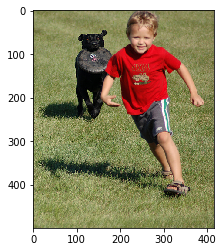

In [15]:
# extract features from each image in the directory
from IPython.display import display
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from numpy import argmax
from numpy import array
from pickle import load
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing.image import load_img
from tensorflow.python.keras.preprocessing.image import img_to_array
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def extract_features(filename):
	# load the VGG16 model
	model = VGG16()
	# re-structure the model by removing the last layer
	#####
	model._layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the image
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# preprocess the image for the VGG model
	image = preprocess_input(image)
	# get features (output of the model for the image)
	feature = model.predict(image, verbose=0)
	#del model
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence using texts_to_sequences (consider first element)
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad sequence for maxlength
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word using both photo and sequence
		yhat = model.predict([photo, sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# load the tokenizer
tokenizer = load(open("gdrive/My Drive/tokenizer.pkl", 'rb'))

# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model("gdrive/My Drive/model_9.h5")

# load and prepare your own image to generate the caption
fname="gdrive/My Drive/imgg.jpg"

photo = extract_features(fname)   
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
# provide your image file name 
#Image(filename=fname) 
print("Description of Photo:"+ description[8:-6])
img=mpimg.imread(fname)
imgplot = plt.imshow(img)